# Image Quilting for Texture Synthesis and Transfer

This notebook contains all of our implemented code and example usage.

Database:

"https://raw.githubusercontent.com/axu2/image-quilting/master/"

"https://people.eecs.berkeley.edu/~efros/research/quilting/figs/transfer/"


In [360]:
class Graph: 
  
    def __init__(self,graph): 
        self.graph = graph # residual graph 
        self.org_graph = [i[:] for i in graph] 
        self.ROW = len(graph) 
        self.COL = len(graph[0])
  
    '''Returns true if there is a path from 
    source 's' to sink 't' in 
    residual graph. Also fills 
    parent[] to store the path '''
    def BFS(self,s, t, parent): 
  
        # Mark all the vertices as not visited 
        visited =[False]*(self.ROW) 
  
        # Create a queue for BFS 
        queue=[] 
  
        # Mark the source node as visited and enqueue it 
        queue.append(s) 
        visited[s] = True
  
        # Standard BFS Loop 
        while queue: 
  
            #Dequeue a vertex from queue and print it 
            u = queue.pop(0) 
  
            # Get all adjacent vertices of 
            # the dequeued vertex u 
            # If a adjacent has not been
            # visited, then mark it 
            # visited and enqueue it 
            for ind, val in enumerate(self.graph[u]): 
                if visited[ind] == False and val > 0 : 
                    queue.append(ind) 
                    visited[ind] = True
                    parent[ind] = u 
  
        # If we reached sink in BFS starting
        # from source, then return 
        # true, else false 
        return True if visited[t] else False
          
    # Function for Depth first search 
    # Traversal of the graph
    def dfs(self, graph,s,visited):
        visited[s]=True
        for i in range(len(graph)):
            if graph[s][i]>0 and not visited[i]:
                self.dfs(graph,i,visited)
  
    # Returns the min-cut of the given graph 
    def minCut(self, source, sink): 
  
        # This array is filled by BFS and to store path 
        parent = [-1]*(self.ROW) 
  
        max_flow = 0 # There is no flow initially
    
        s = 0
  
        # Augment the flow while there is path from source to sink 
        while self.BFS(source, sink, parent) : 
  
            # Find minimum residual capacity of the edges along the 
            # path filled by BFS. Or we can say find the maximum flow 
            # through the path found. 
            path_flow = float("Inf") 
            s = sink 
            while(s != source): 
                path_flow = min (path_flow, self.graph[parent[s]][s]) 
                s = parent[s] 
  
            # Add path flow to overall flow 
            max_flow += path_flow 
  
            # update residual capacities of the edges and reverse edges 
            # along the path 
            v = sink 
            while(v != source): 
                u = parent[v] 
                self.graph[u][v] -= path_flow 
                self.graph[v][u] += path_flow 
                v = parent[v] 
  
        visited=len(self.graph)*[False]
        self.dfs(self.graph,s,visited)

#         print(visited)
  
        # print the edges which initially had weights 
        # but now have 0 weight 
#         for i in range(self.ROW): 
#             for j in range(self.COL): 
#                 if self.graph[i][j] == 0 and self.org_graph[i][j] > 0 and visited[i]: 
#                     print(str(i) + " - " + str(j))
                    
        return visited

In [361]:
class FordFulkersonDFSAdjacencyMatrix:
    def __init__(self) -> None:
        self.visitedToken = 1
        
    def fordFulkerson(self, caps, source, sink):
        n = len(caps)
        visited = [0] * n
        minCut = [False] * n
        maxFlow = 0

        while(True):
            # Try to find an augmenting path from source to sink
            flow = self.dfs(caps, visited, source, sink, float('inf'))
            self.visitedToken += 1
            
            maxFlow += flow
            if flow <= 1e-7:
                for i in range(0,n):
                    if (visited[i] == self.visitedToken-1):
                         minCut[i] = True
#                 print(minCut)
#                 return maxFlow
                return minCut
            
            
    def dfs(self,caps, visited, node, sink, flow):
        #Found sink node, return flow thus far
        if (node == sink): 
            return flow

        cap = caps[node]
        visited[node] = self.visitedToken

        for i in range(len(cap)):
            if visited[i] != self.visitedToken and cap[i] > 0.5:

                if (cap[i] < flow):
                    flow = cap[i]
                dfsFlow = self.dfs(caps, visited, i, sink, flow)

                if (dfsFlow > 0.5):
                    caps[node][i] -= dfsFlow
                    caps[i][node] += dfsFlow
                    return dfsFlow

        return 0

graph = [[0, 6, 0, 8, 0, 0],  # s
     [0, 0, 4, 0, 3, 0],  # 1
     [0, 0, 0, 0, 0, 7],  # 2
     [0, 0, 0, 0, 4, 2],  # 3
     [0, 0, 0, 0, 0, 9],  # 4
     [0, 0, 0, 0, 0, 0]]  # t 

source = 0; sink = 5

ff = FordFulkersonDFSAdjacencyMatrix()

print(ff.fordFulkerson(graph,source,sink))

[True, False, False, True, False, False]


In [362]:
ff.visitedToken

7

# Image Quilting

In [363]:
import numpy as np
import math
from skimage import io, util
import heapq
import cv2
import matplotlib.pyplot as plt
from collections import defaultdict 
import os

images = []

def randomPatch(texture, patchLength):
#     np.random.seed(1111)
    h, w, _ = texture.shape
    i = np.random.randint(h - patchLength)
    j = np.random.randint(w - patchLength)

    return texture[i:i+patchLength, j:j+patchLength]

def normalize_img(img):
    norm = (img - np.min(img)) / (np.max(img) - np.min(img))
    return norm


def L2OverlapDiff(patch, patchLength, overlap, res, y, x):
    error = 0
    
    

    if x > 0:
        left = patch[:, :overlap] - res[y:y+patchLength, x:x+overlap]
        error += np.sum(left**2)

    if y > 0:
        up   = patch[:overlap, :] - res[y:y+overlap, x:x+patchLength]
        error += np.sum(up**2)

    if x > 0 and y > 0:
        corner = patch[:overlap, :overlap] - res[y:y+overlap, x:x+overlap]
        error -= np.sum(corner**2)

    return error
 

def randomBestPatch(texture, patchLength, overlap, res, y, x):
    h, w, _ = texture.shape
    errors = np.zeros((h - patchLength, w - patchLength))

    for i in range(h - patchLength):
        for j in range(w - patchLength):
            patch = texture[i:i+patchLength, j:j+patchLength]
            e = L2OverlapDiff(patch, patchLength, overlap, res, y, x)
            errors[i, j] = e

    i, j = np.unravel_index(np.argmin(errors), errors.shape)
    return texture[i:i+patchLength, j:j+patchLength]

def get_gradient(image,direction):
    # load the input image and convert it to grayscale
    print(image.shape)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # compute gradients along the x and y axis, respectively
    if direction == 'X':
        grad = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        grad = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    magnitude = np.sqrt((grad ** 2))
    return magnitude


def quilt(texture, patchLength, numPatches, mode="cut", sequence=False):
#     texture = util.img_as_float(texture)
    texture = normalize_img(texture)

    overlap = patchLength // 6
    numPatchesHigh, numPatchesWide = numPatches
    
    count = 0

    h = (numPatchesHigh * patchLength) - (numPatchesHigh - 1) * overlap
    w = (numPatchesWide * patchLength) - (numPatchesWide - 1) * overlap

    res = np.zeros((h, w, texture.shape[2]))

    for i in range(numPatchesHigh):
        for j in range(numPatchesWide):
            count += 1
            y = i * (patchLength - overlap)
            x = j * (patchLength - overlap)

            if i == 0 and j == 0 or mode == "random":
                patch = randomPatch(texture, patchLength)
            elif mode == "best":
                patch = randomBestPatch(texture, patchLength, overlap, res, y, x)
            elif mode == "cut":
                patch = randomBestPatch(texture, patchLength, overlap, res, y, x)
                patch = minCutPatch(patch, patchLength, overlap, res, y, x)
                
            res[y:y+patchLength, x:x+patchLength] = patch
            
            if sequence:
                io.imshow(res)
                io.show()
                
#             if count == 2:
#                 return res
      
    return res


def quiltSize(texture, patchLength, shape, mode="cut"):
    overlap = patchLength // 6
    h, w = shape

    numPatchesHigh = math.ceil((h - patchLength) / (patchLength - overlap)) + 1 or 1
    numPatchesWide = math.ceil((w - patchLength) / (patchLength - overlap)) + 1 or 1
    res = quilt(texture, patchLength, (numPatchesHigh, numPatchesWide), mode)

    return res[:h, :w]

In [364]:
def minCutPatch(patch, patchLength, overlap, res, y, x):
    patch = patch.copy()
    dy, dx, _ = patch.shape
    minCut = np.zeros_like(patch, dtype=bool)
#     plt.figure()

#     f, axarr = plt.subplots(1,1)
      
    if x > 0:
        left = patch[:, :overlap] - res[y:y+dy, x:x+overlap]
        patchA = patch[:, :overlap]
        patchB = res[y:y+dy, x:x+overlap]
        
#         plt.figure()

#         f, axarr = plt.subplots(3,1) 

#         axarr[0].imshow(patchA)
#         axarr[1].imshow(res)
#         axarr[1].imshow(patchB)
#         axarr[3].imshow(patch)
        
        
#         for i in range(0, patchB.shape[0]):
#             for j in range(0, patchB.shape[1]):
#                 if (np.array([0,0,0]) == patchB[i][j]).all():
#                     print("O:",patch[17][17],patch[x+i][y+j])
#                     print("B", patchB[0][0],patch[0][2])
        
        leftL2 = np.sum(left**2, axis=2)
        
        
        overlapped_graph = graph_min_cut(patchA, patchB)
        
        visited = minimum_graph_cut(overlapped_graph)
        
        res_patch = get_res_patch(visited, patchA, patchB,res)

        for r in range(0,patchA.shape[0]):
            for c in range(0,patchA.shape[1]):
                patch[r][c] = res_patch[r][c]
            

    if y > 0:
        up = patch[:overlap, :] - res[y:y+overlap, x:x+dx]
        patchA = patch[:overlap, :]
        patchB = res[y:y+overlap, x:x+dx]
        
        patchA = cv2.rotate(patchA, cv2.cv2.ROTATE_90_CLOCKWISE)
        patchB = cv2.rotate(patchB, cv2.cv2.ROTATE_90_CLOCKWISE)
        
        upL2 = np.sum(up**2, axis=2)
        
        overlapped_graph = graph_min_cut(patchA, patchB)
        
        visited = minimum_graph_cut(overlapped_graph)
    
        res_patch = get_res_patch(visited, patchA, patchB,res)
        
        res_patch = cv2.rotate(res_patch, cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)
        
        for r in range(0,patchA.shape[1]):
            for c in range(0,patchA.shape[0]):
                patch[r][c] = res_patch[r][c]

#     np.copyto(patch, res[y:y+dy, x:x+dx], where=minCut)
    
#     np.copyto(patch, res_patch, where=minCut)

#     patch[0:20, 0:3] = res_patch

    return patch

In [365]:
def get_res_patch(visited, patchA, patchB,res):
    node_map = {}
#     res_patch = [[] for row in range(len(patchA))]
    res_patch = np.zeros(shape=(patchA.shape[0],patchA.shape[1],3))
    count = 1
    for r in range(len(patchA[0])):
        for c in range(len(patchA)):
            node_map[count] = (c,r)
            count += 1
            
    region = np.zeros_like(res_patch)
    
#     print(res_patch.shape,patchB.shape)
    
    for i in range(1,len(visited)-1):
        row = node_map[i][0]
        col = node_map[i][1]
        
        if visited[i]:
            res_patch[row][col] = np.array(patchA[row][col])
            region[row][col] = np.array([255.0,0.0,0.0])
#             print("A",row,col,patchA[row][col],res_patch[row][col])
        else:
            res_patch[row][col] = np.array(patchB[row][col])
#             print("B",row,col,patchB[row][col],res_patch[row][col])
            region[row][col] = np.array([0.0,0.0,255.0])

    images.append(region)
            
    return res_patch

In [366]:
def graph_min_cut(patchA, patchB):
#     rows = patchA.shape[0]+2
#     cols = patchA.shape[1]+2
    
    nodes = patchA.shape[0] * patchA.shape[1] + 2
    
    graph = [[0]*(nodes) for row in range(nodes)]
    
    node_map = {}
    
    count = 1
    
    for r in range(len(patchA[0])):
        for c in range(len(patchA)):
            node_map[count] = (c,r)
            count += 1
            
    count -= 1
    
    for r in range(0,nodes):
        for c in range(0,nodes):
            if (r == 0 and 1<=c<=len(patchA)) or (c == nodes-1 and count-len(patchA)<=r<=count):
                graph[r][c] = float('inf')
            elif r != 0:
                if r + 20 < nodes-2 and c == r+20:
                    prs,pcs = node_map[r]
                    prd,pcd = node_map[r+20]
#                     graph[r][r+20] = np.average(abs(patchA[prs][pcs] - patchB[prs][pcs])) + np.average(abs(patchA[prd][pcd] - patchB[prd][pcd]))
#                     graph[r][r+20] = np.linalg.norm(patchA[prs][pcs] - patchB[prs][pcs]) + np.linalg.norm(patchA[prd][pcd] - patchB[prd][pcd])
                    weight = np.sum(np.square(patchA[prs][pcs] - patchB[prs][pcs]) + np.square(patchA[prd][pcd] - patchB[prd][pcd]))
                    norm = np.sum(np.square(patchA[prs][pcs] - patchA[prd][pcd]) + np.square(patchB[prs][pcs] - patchB[prd][pcd]),)
                    graph[r][r+20] = weight/(norm+1e-10)
                if r + 1 < nodes-2 and c == r + 1:
                    if (c % len(patchA)) != 1:
                        prs,pcs = node_map[r]
                        prd,pcd = node_map[r+1]
#                         graph[r][r+1] = np.average(abs(patchA[prs][pcs] - patchB[prs][pcs])) + np.average(abs(patchA[prd][pcd] - patchB[prd][pcd]))
#                         graph[r][r+1] = np.linalg.norm(patchA[prs][pcs] - patchB[prs][pcs]) + np.linalg.norm(patchA[prd][pcd] - patchB[prd][pcd])
                        weight = np.sum(np.square(patchA[prs][pcs] - patchB[prs][pcs]) + np.square(patchA[prd][pcd] - patchB[prd][pcd]))
                        norm = np.sum(np.square(patchA[prs][pcs] - patchA[prd][pcd]) + np.square(patchB[prs][pcs] - patchB[prd][pcd]))
                        graph[r][r+1] = weight/(norm+1e-10)

#     print(graph)
    return graph          
    

In [367]:
def minimum_graph_cut(overlapped_graph):
  
    source = 0; sink = len(overlapped_graph) - 1
    
#     g = Graph(overlapped_graph) 
#     visited = g.minCut(source, sink)
    ff = FordFulkersonDFSAdjacencyMatrix()
    visited = ff.fordFulkerson(overlapped_graph,source,sink)
    
#     print(visited)
    
    return visited

(64, 64, 3)


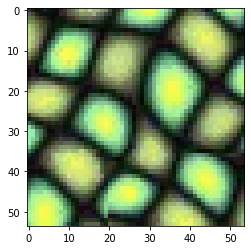

In [368]:
# s = "https://raw.githubusercontent.com/axu2/image-quilting/master/"

# texture = io.imread("test.png")
# io.show()

texture = cv2.imread(os.path.join('test.png'))
print(texture.shape)
texture = cv2.cvtColor(texture, cv2.COLOR_BGR2RGB)

# plt.imshow(texture)

# io.imshow(quilt(texture, 25, (6, 6), "random"))
# io.show()

# io.imshow(quilt(texture, 25, (6, 6), "best"))
# io.show()

plt.imshow(quilt(texture, 20, (3, 3), "cut"))
# io.show()

new_image = quilt(texture, 20, (3, 3), "cut")

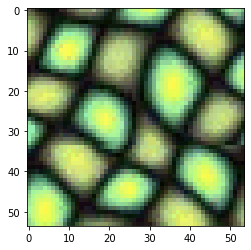

In [369]:
plt.imshow(quilt(texture, 20, (3, 3), "best"))

In [370]:
img = quilt(texture, 20, (3, 3), "best")

In [237]:
import matplotlib
matplotlib.image.imsave('name.png', new_image)

In [116]:
cv2.imwrite('filenam.png',img)

True

In [ ]:
import Image
img = Image.open(FILENAME)
img.size
Out[32]: (250, 250)

In [27]: img = img.resize((160, 240), Image.ANTIALIAS)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

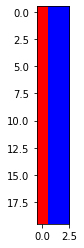

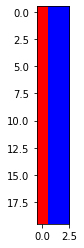

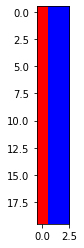

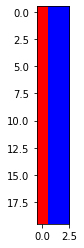

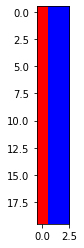

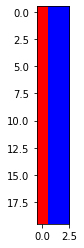

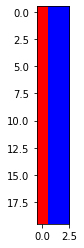

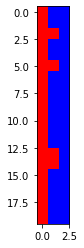

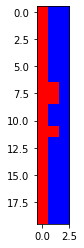

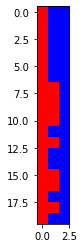

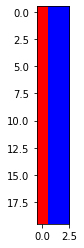

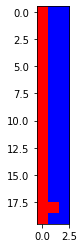

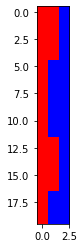

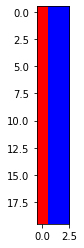

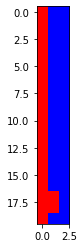

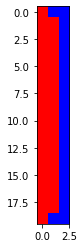

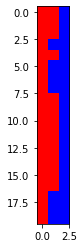

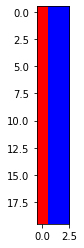

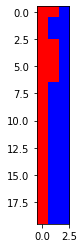

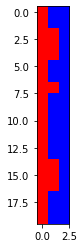

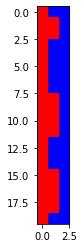

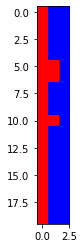

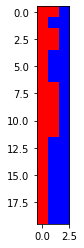

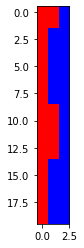

In [371]:
# plt.figure((10,5))
# f, axarr = plt.subplots(len(images),1) 

for i,img in enumerate(images):
    plt.figure()
    plt.imshow(img)

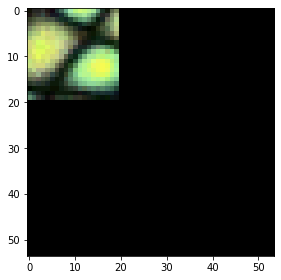

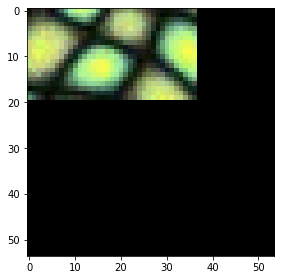

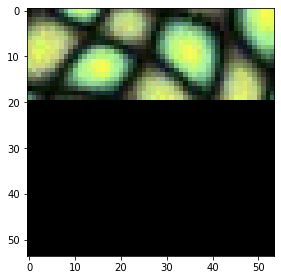

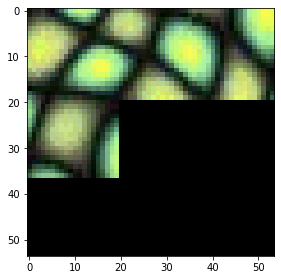

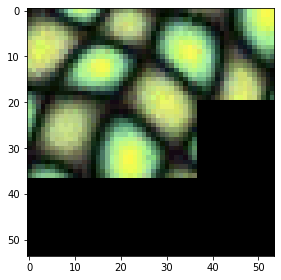

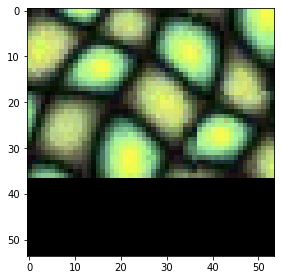

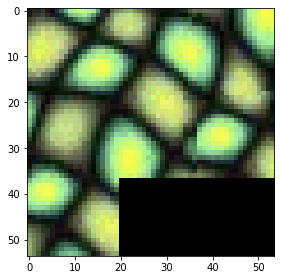

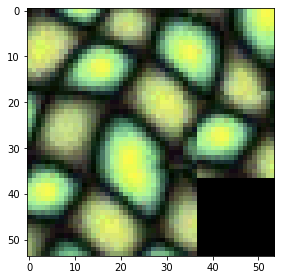

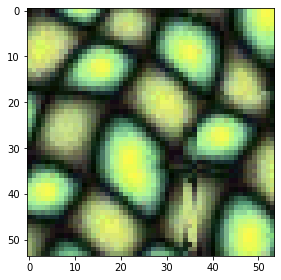

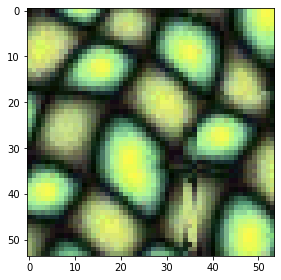

In [1293]:
io.imshow(quilt(texture, 20, (3, 3), "cut", True))
io.show()

In [705]:
# for i in range(0, texture.shape[0]):
#     for j in range(0, texture.shape[1]):
#         print(texture[i][j])
#         if (np.array([0,0,0]) == texture[i][j]).all():
#             print("Yes")